I am training model with CIFAR 10 data base.
The images in the data base are classified into 10 categories as following. The number index also represents their categorical index in this model.
0. airplane										
1. automobile										
2. bird										
3. cat										
4. deer										
5. dog										
6. frog										
7. horse										
8. ship										
9. truck

The theory in this project are:
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import seaborn as sn 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the CIFAR-10 dataset
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='./Data', train=True, download=True, transform=transform)
valid_data = datasets.CIFAR10(root='./Data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


In [3]:
display(train_data)
print('-' * 50)
display(valid_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./Data
    Split: Train
    StandardTransform
Transform: ToTensor()

--------------------------------------------------


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
# Create data loader
torch.manual_seed(101)  # for reproducible results

BATCH_SIZE = 10
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Label: [    1     5     8     1     6     1     6     3     7     9]
Class:  automobile dog ship automobile frog automobile frog cat horse truck


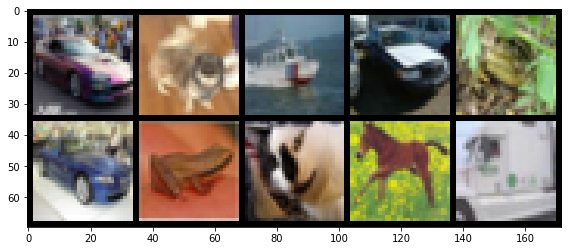

In [7]:
# View images in the database
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # widen the printed array

# Grab the first batch of 10 images
for images, labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
ima = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(ima.numpy(), (1, 2, 0))); # because 0, 1, and 2 in the original image tensor represent RGB, horizontal axis, and vertical axis.

In [22]:
# Define the model

class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(8, 16, 3, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            # nn.Conv2d(32, 64, 3, 1),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2, 0),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(6 * 6 * 16, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 10)
        )
        # self.conv1 = nn.Conv2d(3, 6, 3, 1)  # 3 input channels, 6 output channels, 3 of kernel size, and 1 pixel of stride
        # self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # self.fc1 = nn.Linear(6 * 6 * 16, 120)   # to fit 32x32 images with 3x3 filters 
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.cnn(x)
        # out = out.view(-1, 6 * 6 * 16)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
    
    # def forward(self, X):
    #     X = F.relu(self.conv1(X))
    #     X = F.max_pool2d(X, 2, 2)
    #     X = F.relu(self.conv2(X))
    #     X = F.max_pool2d(X, 2, 2)
    #     X = X.view(-1, 6*6*16)
    #     X = F.relu(self.fc1(X))
    #     X = F.relu(self.fc2(X))
    #     X = self.fc3(X)
    #     return F.log_softmax(X, dim=1)

Here the number 6 in function "self.fc1 = nn.Linear(6 * 6 * 16, 120)" comes from convolutional layers and pooling layers. The original images in CIFAR10 are 32x32.\
After the first convolutional layer its side becomes 32-2 = 30 (assume x and y sides are equal). Then pooling layer generate 30 / 2 = 15 pixels.\
After the second convolutional layer it becomes 15 - 2 = 13, then second pooling layer leads to 13 / 2 = 6.5.\
Thus it rounds down to 6 pixels per side.

In [ ]:
# Another model
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [23]:
model = CNNClassifier()
model

CNNClassifier(
  (cnn): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=576, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [24]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [25]:
count_parameters(model)

   216
     8
     8
     8
  1152
    16
    16
    16
589824
  1024
524288
   512
  5120
    10
______
1122218


In [12]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [32]:
# fix random seed for reproducibility
myseed = 7777
same_seeds(myseed)

device = get_device()
print(f'DEVICE: {device}')

# training parameters
n_epochs = 20               # number of training epoch
learning_rate = 0.0001       # learning rate

# the path where checkpoint saved
model_path = './deep_learinging_model_dropout0.ckpt'

model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cuda


In [33]:
# start training

import time
start_time = time.time()

n_epochs = 50
best_acc = 0
stale = 0
patience = 20

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(n_epochs):
    epoch += 1
    trn_corr = 0
    trn_loss = 0
    
    # training
    model.train()
    for i, data in enumerate(train_loader):
        i += 1
        X_train, y_train = data
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        # Apply the model
        y_pred = model(X_train)
        batch_loss = criterion(y_pred, y_train)
        
        # Update parameters
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
 
        # Tally the number of correct predictions
        _, predicted = torch.max(y_pred.data, dim=1)
        batch_corr = (predicted == y_train).sum().item()
        trn_corr += batch_corr
        trn_loss += batch_loss.item()
      
        # Print interim results
        if i%1000 == 0:
            print(f'epoch: {epoch:2} training batch: {i:4} [{BATCH_SIZE * i:6}/ {BATCH_SIZE * len(train_loader):6}]  loss: {batch_loss.item():10.8f}  accuracy: {trn_corr*100/(BATCH_SIZE * i):7.3f}%')
        
    train_losses.append(trn_loss / (BATCH_SIZE * i))
    train_accs.append(trn_corr / (BATCH_SIZE * i) * 100)
        
    # validation
    if len(valid_loader) > 0:
        val_corr = 0
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(valid_loader):
                i += 1
                X_test, y_test = data
                X_test, y_test = X_test.to(device), y_test.to(device)

                # Apply the model
                y_val = model(X_test)
                batch_loss = criterion(y_val, y_test)

                # Tally the number of correct predictions
                _, predicted = torch.max(y_val.data, 1)
                val_corr += (predicted == y_test).sum().item()
                val_loss += batch_loss.item()
                
                # Print interim results
                if i%500 == 0:
                    print(f'epoch: {epoch:2} val batch: {i:4} [{BATCH_SIZE * i:6}/ {BATCH_SIZE * len(valid_loader):6}]  loss: {batch_loss.item():10.8f}  accuracy: {val_corr*100/(BATCH_SIZE * i):7.3f}%')
                
            valid_losses.append(val_loss / (BATCH_SIZE * i))
            valid_accs.append(val_corr / (BATCH_SIZE * i) * 100 )
    
    # if the model improves, save a checkpoint at this epoch
    val_acc = val_corr / (BATCH_SIZE * i) * 100
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print('=====saving model with acc {:.3f}%====='.format(best_acc))
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stoppin")
            break
    print('-' * 100)
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  1 training batch: 1000 [ 10000/  50000]  loss: 1.95694125  accuracy:  34.410%
epoch:  1 training batch: 2000 [ 20000/  50000]  loss: 1.30843568  accuracy:  39.415%
epoch:  1 training batch: 3000 [ 30000/  50000]  loss: 1.28669786  accuracy:  41.937%
epoch:  1 training batch: 4000 [ 40000/  50000]  loss: 1.46539700  accuracy:  43.680%
epoch:  1 training batch: 5000 [ 50000/  50000]  loss: 1.09039557  accuracy:  45.202%
epoch:  1 val batch:  500 [  5000/  10000]  loss: 1.46681559  accuracy:  56.020%
epoch:  1 val batch: 1000 [ 10000/  10000]  loss: 1.44087601  accuracy:  55.270%
=====saving model with acc 55.270%=====
----------------------------------------------------------------------------------------------------
epoch:  2 training batch: 1000 [ 10000/  50000]  loss: 0.68794578  accuracy:  54.260%
epoch:  2 training batch: 2000 [ 20000/  50000]  loss: 1.45000386  accuracy:  54.980%
epoch:  2 training batch: 3000 [ 30000/  50000]  loss: 0.99580586  accuracy:  55.593%
epoch:  2

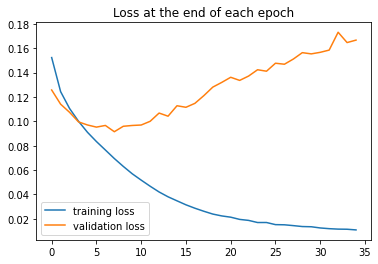

In [34]:
plt.plot(train_losses, label='training loss')
plt.plot(valid_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

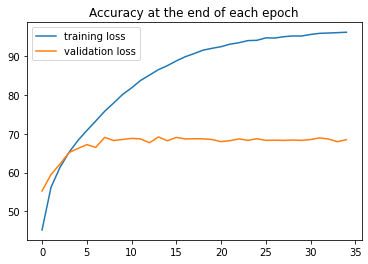

In [35]:
plt.plot(train_accs, label='training loss')
plt.plot(valid_accs, label='validation loss')
plt.title('Accuracy at the end of each epoch')
plt.legend();